In [26]:
# !pip install pandas scipy pandas
#!pip install --upgrade https://github.com/EmilWine/gpuRIR/zipball/master

In [27]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from math import ceil
import librosa
import librosa.display
import gpuRIR
import scipy.signal as signal
import pandas as ps
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d
from ipywidgets import *
from scipy.optimize import linear_sum_assignment
from multiprocessing import Manager, Pool

%matplotlib nbagg

In [28]:
%matplotlib nbagg

In [29]:
room_sz = [3,2.2,2.5]  # Size of the room [m]
nb_src = 1  # Number of sources
pos_src = np.array([[0.6,1.0,1.0]]) # Positions of the sources ([m]
nb_rcv = 2 # Number of receivers
pos_rcv = np.array([[0.5,1.0,1.0],[0.7,1.0,1.0]]) # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) 
# Vectors pointing in the same direction than the receivers
mic_pattern = "omni" # Receiver polar pattern
abs_weights = [1.0]*5+[1.0] # Absortion coefficient ratios of the walls
T60 = 1.0 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 5.0 # Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
Tw = 3 #samples window -  This is the smearing factor
fs=48000*2 # Sampling frequency [Hz]
c = 343

In [30]:
## Helper functions
def envelope(sig_in): 
    return np.abs(signal.hilbert(sig_in))

def energy_decay(rir):
    e_rir = np.cumsum(np.abs(rir)**2)
    e_rir = e_rir[-1] - e_rir
    e_rir /= e_rir[0]
    return e_rir

def tvec(vec,fs,centered=False): 
    temp_time = 1000*np.arange(len(vec)) / fs
    if centered:
        temp_time -= np.mean(temp_time)
    return temp_time

def window_framing(arr,win_size,win_step):
    framed = []
    idx = 0
    hann_window = signal.windows.hann(win_size)
    while idx <= len(arr) - win_size:
        framed.append(hann_window * arr[idx:(idx+win_size)].tolist())
        idx += win_step
    return np.array(framed).T


def to_db(vec):
    return 20*np.log10(np.abs(vec) + 1e-6)


# Display array configuraion

<IPython.core.display.Javascript object>


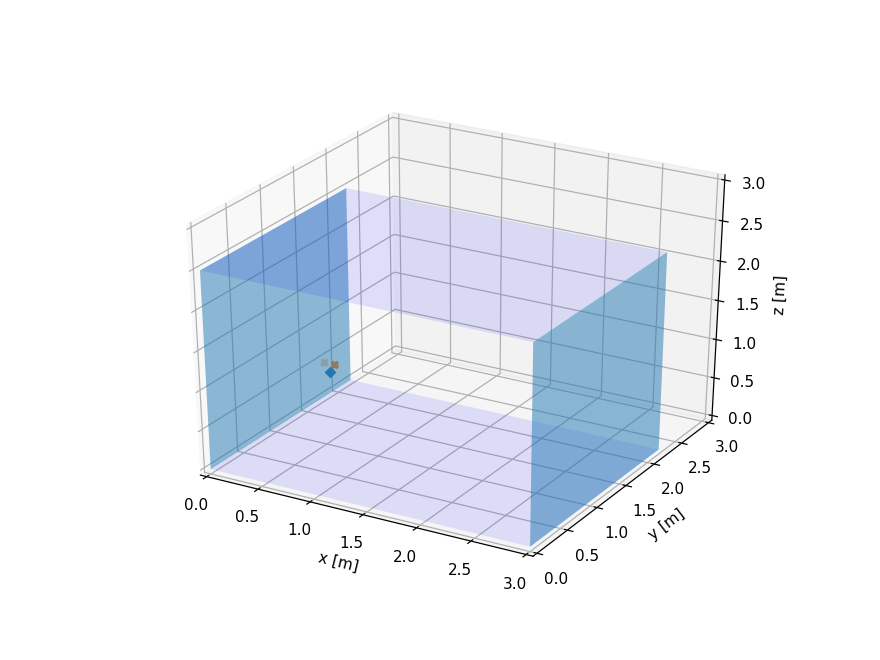

(0, 3)

In [31]:
import matplotlib.pyplot as plt

wx,wy,wz = room_sz

bot = [(0, 0, 0),
       (wx, 0, 0),
       (wx, wy, 0),
       (0, wy, 0),
       ]

top =  [(0, 0, wz),
       (wx, 0, wz),
       (wx, wy, wz),
       (0, wy, wz),
       ]

p1 =  [(0, 0, wz),
       (0, wy, wz),
       (0, wy, 0),
       (0, 0, 0),
       ]

p2 =  [(wx, 0, wz),
       (wx, wy, wz),
       (wx, wy, 0),
       (wx, 0, 0),
       ]


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
face1 = mp3d.art3d.Poly3DCollection([bot], alpha=0.1, linewidth=1)
face2 = mp3d.art3d.Poly3DCollection([top], alpha=0.1, linewidth=1)
face3 = mp3d.art3d.Poly3DCollection([p1], alpha=0.5, linewidth=1)
face4 = mp3d.art3d.Poly3DCollection([p2], alpha=0.5, linewidth=1)
face1.set_facecolor((0, 0, 1))
face2.set_facecolor((0, 0, 1))

ax.scatter(pos_src[:,0],pos_src[:,1],pos_src[:,2],label="Sources",marker='D')
ax.scatter(pos_rcv[:,0],pos_rcv[:,1],pos_rcv[:,2],label="Receivers",marker='X')

ax.add_collection3d(face1)
ax.add_collection3d(face2)
ax.add_collection3d(face3)
ax.add_collection3d(face4)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_xlim([0,3])
ax.set_ylim([0,3])
ax.set_zlim([0,3])


In [32]:
beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension


In [33]:
Taus = gpuRIR.simulateTaus(room_sz, beta, pos_src, pos_rcv, nb_img, fs, \
                           orV_rcv=orV_rcv, mic_pattern=mic_pattern,c=c)
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax,\
                          Tw, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern,c=c)

<IPython.core.display.Javascript object>


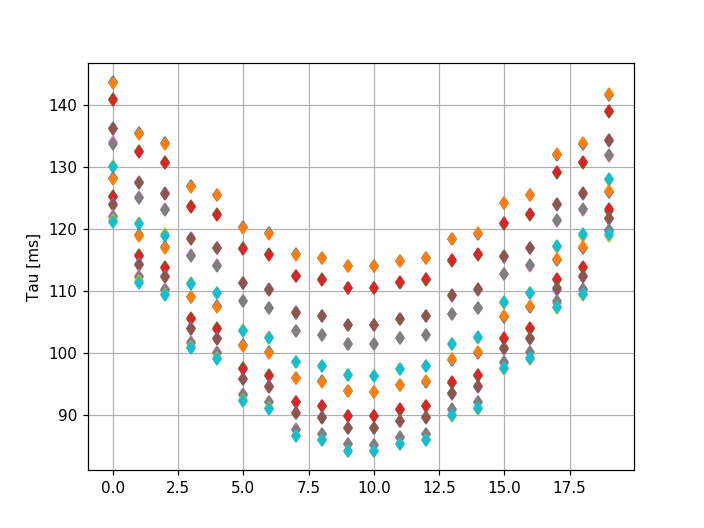

In [34]:
stride = nb_img[1]*nb_img[2]
plt.figure()
for i in range(10):
    plt.plot(1000*Taus[0,1,i:-1:stride]/fs,'d')
    plt.plot(1000*Taus[0,0,i:-1:stride]/fs,'d')
plt.ylabel('Tau [ms]')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


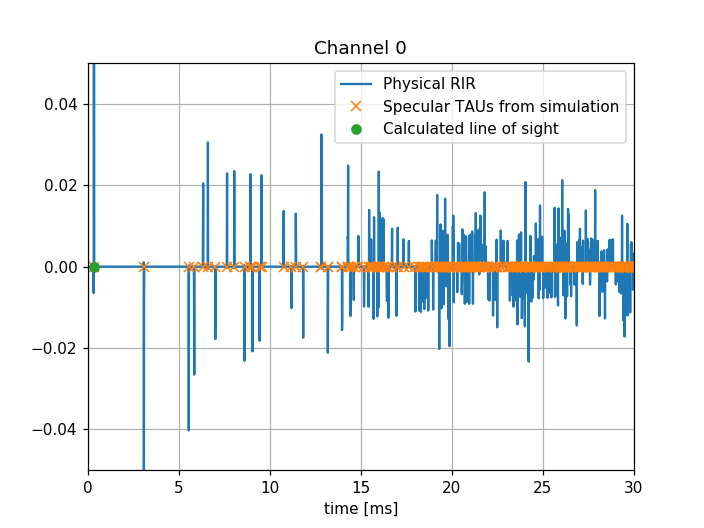

In [35]:
# t = np.arange(int(ceil(Tmax * fs))) / fs
t = tvec(RIRs[0,0,:],fs)
direct_tau = np.linalg.norm(pos_src - pos_rcv[0,:])/343

plt.figure()
plt.title("Channel 0")
plt.plot(t,RIRs[0,0,:],label = 'Physical RIR')
plt.plot(1000*Taus[0,0]/fs,[0]*len(Taus[0,0]),'x',label="Specular TAUs from simulation")
plt.plot(1000*direct_tau,0,'o',label="Calculated line of sight")
plt.xlabel('time [ms]')
plt.legend()


plt.xlim([0,30])
plt.ylim([-0.05,0.05])
plt.grid()
plt.show()

In [36]:
## Calculate Optimal FFT window length

dmax = 0
for i in range(len(pos_rcv)):
    for j in range(len(pos_rcv)):
        dtmp = np.linalg.norm(pos_rcv[i,:]-pos_rcv[j,:])
        dmax = dmax if dmax > dtmp else dtmp

        
tau_max_ms = 1000*dmax/343

window_duration = 2*tau_max_ms + tau_max_ms #the extra is to avoid wrapping in cross correlation

Nhop = int(np.ceil(window_duration*fs/1000/4))
Nfft = Nhop * 4

print("FFT={0}, Hop={1}, Window time={2:.2f}ms".format(Nfft,Nhop,1000*Nfft/fs))

# dmax = np.linalg.norm(np.diff(pos_rcv,axis=0),axis=-1)

FFT=84, Hop=21, Window time=0.88ms


<IPython.core.display.Javascript object>


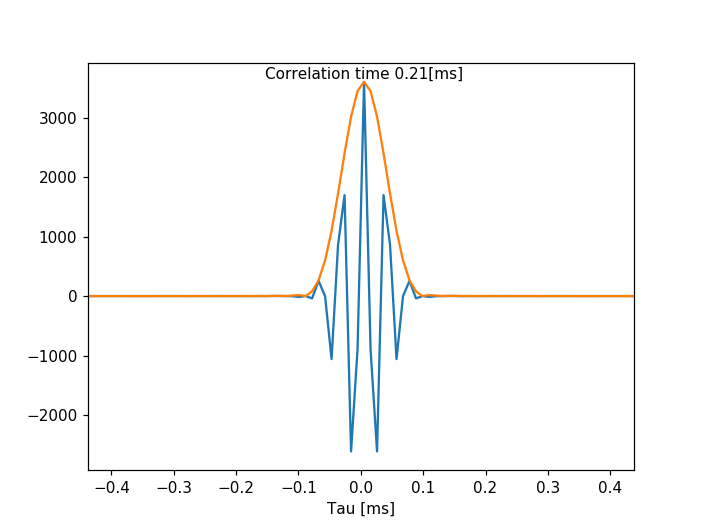

<IPython.core.display.Javascript object>


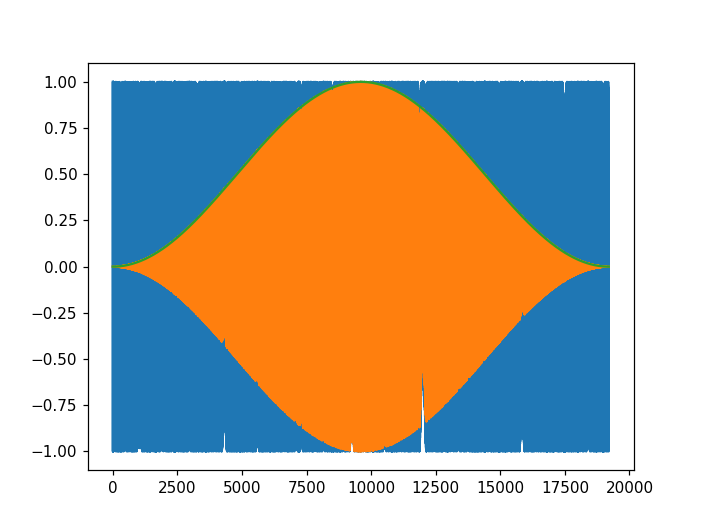

<IPython.core.display.Javascript object>


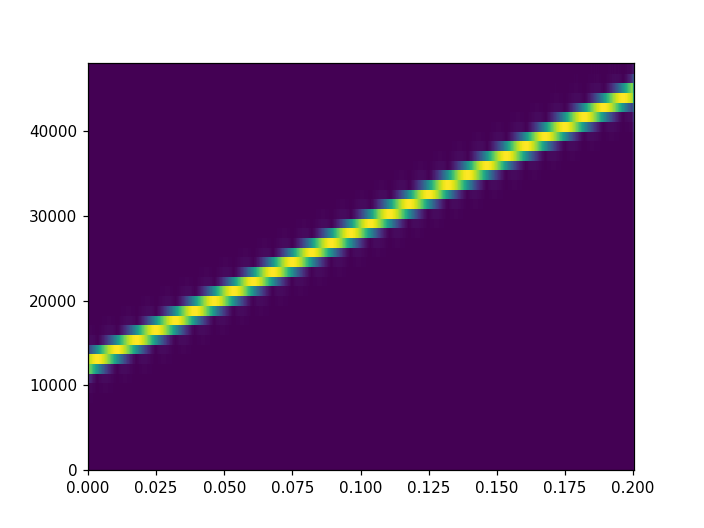

In [37]:
## Logchirp
t_probe = 0.2
t = np.arange(int(ceil(t_probe * fs))) / fs

fmin = 12000
fmax = 44000

probe_sig = signal.chirp(t,fmin,t_probe,fmax,method="linear")
window = signal.windows.hann(len(probe_sig))
probe_windowed = window*probe_sig
probe_corr = signal.correlate(probe_windowed,probe_windowed,'same')
probe_env = envelope(probe_corr)

m1 = np.sum(t*np.abs(probe_env))/np.sum(np.abs(probe_env))
m2 = np.sqrt(np.sum( ((t-m1)**2)*np.abs(probe_env))/np.sum(np.abs(probe_env)))
m1 -= np.mean(t)

peak_width_ms = 6*m2*1000

plt.figure()
plt.plot(1000*(t-np.mean(t)),probe_corr)
plt.plot(1000*(t-np.mean(t)),np.abs(probe_env))
plt.text(1000*m1,np.max(np.abs(probe_env)),"Correlation time {0:.2f}[ms]".format(peak_width_ms),\
         horizontalalignment='center',verticalalignment='bottom')
plt.xlim([-1000*Nfft/2/fs,1000*Nfft/2/fs])
plt.xlabel('Tau [ms]')

plt.figure()
plt.plot(probe_sig)
plt.plot(probe_windowed)
plt.plot(window)

freqs, times,probe_stft = signal.stft(probe_sig,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=True)

plt.figure()
plt.pcolormesh(times,freqs,np.abs(probe_stft))
plt.show()





<IPython.core.display.Javascript object>


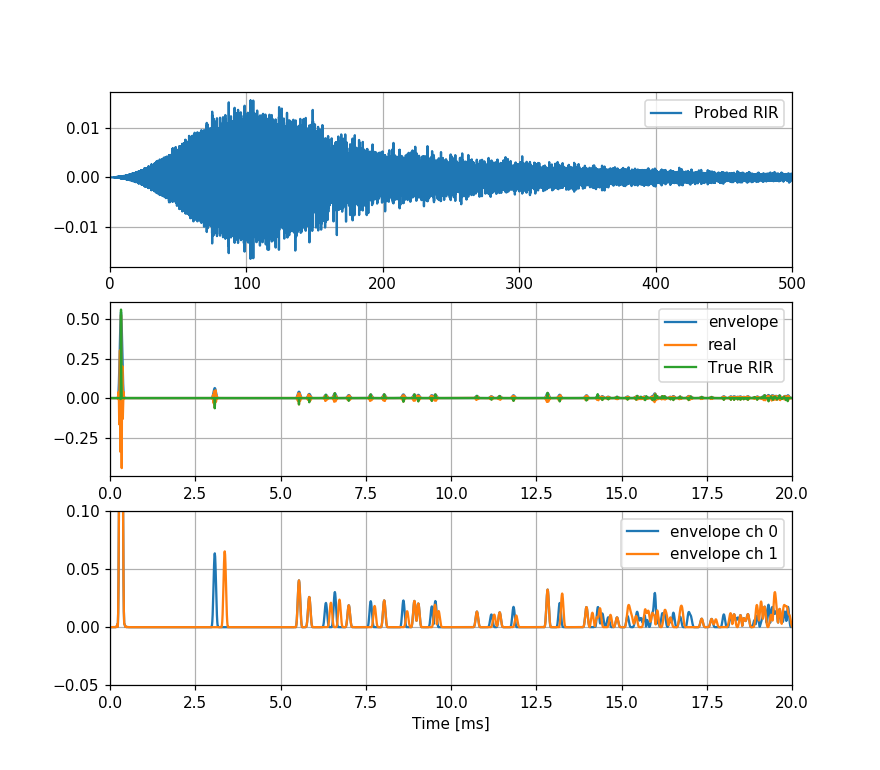

In [38]:
df = ps.DataFrame()

normed_probe_windowed = probe_windowed / np.linalg.norm(probe_windowed)
for src in range(nb_src):
    for rcv in range(nb_rcv):
        rir = RIRs[src,rcv,:]
        prir = signal.convolve(rir,normed_probe_windowed,'full',method="direct")
        ds_rir = np.flip(signal.convolve(np.flip(prir),normed_probe_windowed))[len(normed_probe_windowed)-1:]
        framed_rir = window_framing(ds_rir, Nfft,Nhop)
        _,_,stft_rir = signal.stft(RIRs[src,rcv,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        _,_,stft_drir = signal.stft(ds_rir,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        
        e_rir = energy_decay(rir)
        e_ds_rir = energy_decay(ds_rir)
        
        df = df.append({"src":int(src),"rcv":int(rcv),"RIR":RIRs[src,rcv,:],"pRIR":prir,
                       "stft_RIR":stft_rir,"stft_dRIR":stft_drir, "dRIR":ds_rir, "framed_RIR": framed_rir,
                       "TAU":1000*Taus[src,rcv]/fs,"eRIR":e_rir,"edRIR":e_ds_rir},
                       ignore_index=True)

plt.figure(figsize=(8,7))

plt.subplot(311)
plt.plot(tvec(df.iloc[0].pRIR,fs),df.iloc[0].pRIR,label="Probed RIR")
plt.xlim([0,500])
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot(tvec(df.iloc[0].dRIR,fs),envelope(df.iloc[0].dRIR),label="envelope")
plt.plot(tvec(df.iloc[0].dRIR,fs),df.iloc[0].dRIR,label="real")
plt.plot(tvec(df.iloc[0].RIR,fs),df.iloc[0].RIR,label="True RIR")
plt.xlim([0,20])
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot(tvec(df.iloc[0].dRIR,fs),envelope(df.iloc[0].dRIR),label="envelope ch 0")
plt.plot(tvec(df.iloc[1].dRIR,fs),envelope(df.iloc[1].dRIR),label="envelope ch 1")
plt.xlim([0,20])
plt.ylim([-0.05,0.1])
plt.xlabel('Time [ms]')
plt.legend()
plt.grid()

cc = (df.iloc[0].stft_RIR * df.iloc[1].stft_RIR.conj()) / \
    (1e-6 + np.abs(df.iloc[0].stft_RIR) * np.abs(df.iloc[1].stft_RIR))
plt.show()

## Mixning boundary time

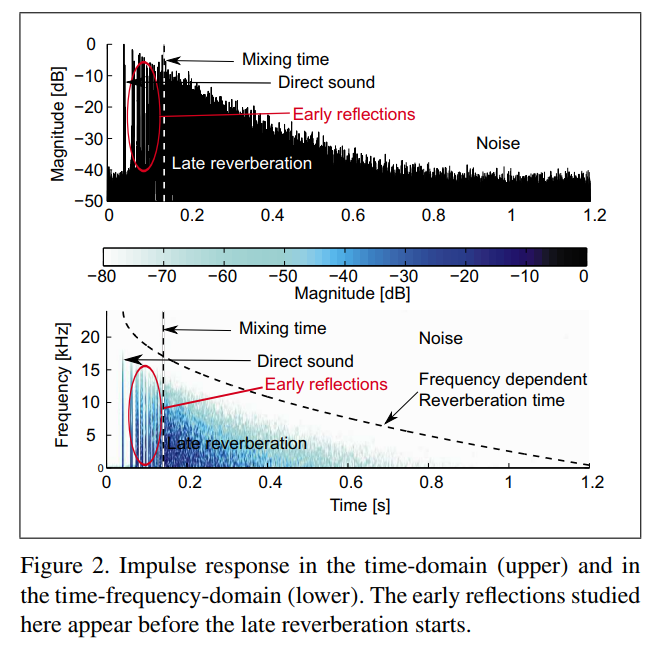

### Energy decay

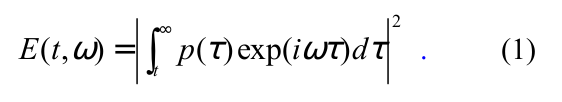

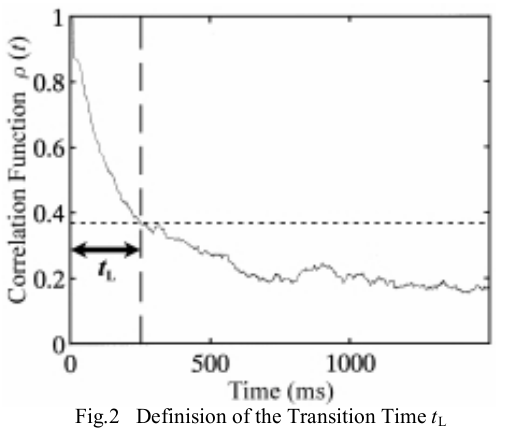

<IPython.core.display.Javascript object>


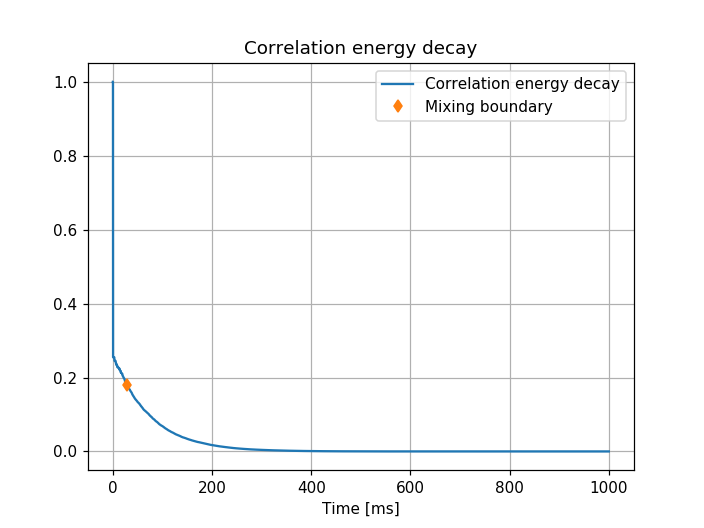

Estimated diffuse time 28.39 [ms]
FFT frames to take 129


In [39]:
te = tvec(df.iloc[0].eRIR,fs)

## Check energy only after direct sound
energy_decay_no_ls = df.iloc[0].eRIR/df.iloc[0].eRIR[np.argmin(te<1000*direct_tau + peak_width_ms)]

imix = np.argmax(energy_decay_no_ls<1/np.sqrt(2))

te_mix = te[imix]
stft_nmix =  int(te_mix*fs/1000/Nhop) # mix in STFT frames to take

plt.figure()
plt.title("Correlation energy decay")
plt.plot(tvec(df.iloc[0].eRIR,fs),df.iloc[0].eRIR,label = "Correlation energy decay")
plt.plot(tvec(df.iloc[0].eRIR,fs)[imix],df.iloc[0].eRIR[imix],'d',label="Mixing boundary")
plt.xlabel('Time [ms]')
plt.legend()
plt.grid()
plt.show()
print("Estimated diffuse time {0:.2f} [ms]".format(te_mix))
print("FFT frames to take {0}".format(stft_nmix))

## GCC - PHAT

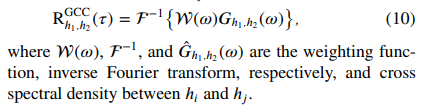


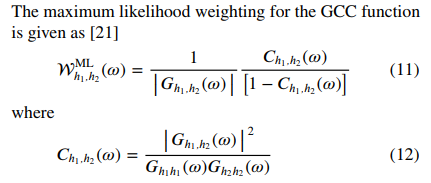

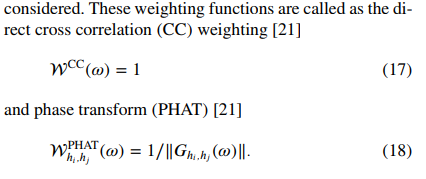

## TDOA Analysis

In [40]:
def gcc_phat(vec1,vec2):
    regularization = 1e-1 * np.sqrt(np.max(np.abs(vec1)*np.abs(vec2)))
    vec1n = vec1/(np.abs(vec1) + regularization)
    vec2n = vec2/(np.abs(vec2) + regularization)
    return (vec1n * vec2n.conj())

In [41]:
cc = gcc_phat(df.iloc[0].stft_dRIR,df.iloc[1].stft_dRIR)
_,icc = signal.istft(cc,nperseg=Nfft,noverlap=0,input_onesided = False)
icc = icc.reshape(-1,Nfft).T    

<IPython.core.display.Javascript object>


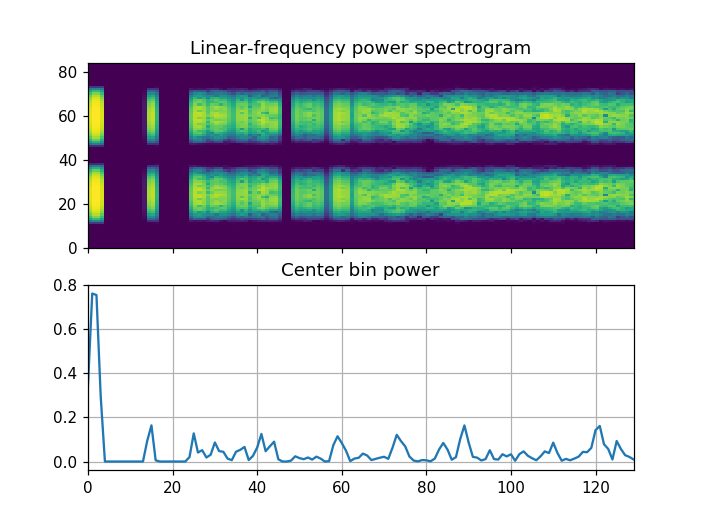

In [42]:
D = to_db(cc)
center_bin = int((Nfft*(fmax-fmin))/fs)
fig, (ax0,ax1) = plt.subplots(2,1,sharex=True)
ax0.pcolormesh(D-np.max(D))
ax0.set_title('Linear-frequency power spectrogram')

ax1.set_title('Center bin power')
ax1.plot(np.abs(cc[center_bin,:]))
ax1.grid()

plt.xlim([0,stft_nmix])
plt.plot()
plt.show()

In [43]:
df[(df.rcv==0) & (df.src==0)].TAU.iloc[0]

array([143.63364583, 140.8369375 , 136.22284375, ..., 132.60251042,
       135.34333333, 140.56810417])

<IPython.core.display.Javascript object>


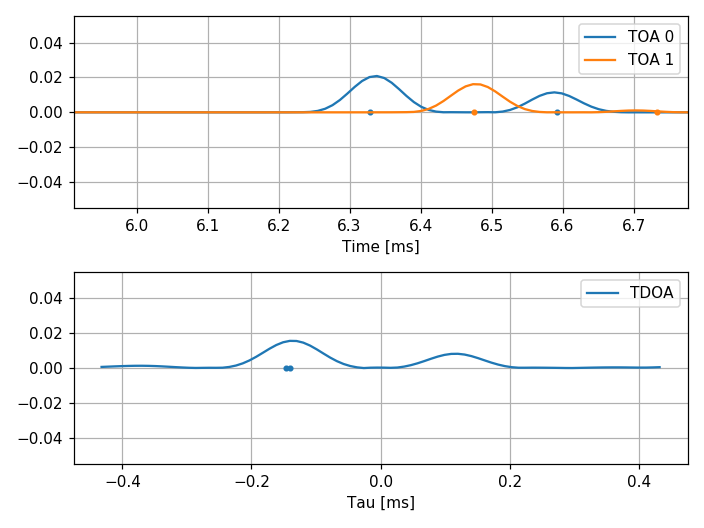

interactive(children=(IntSlider(value=0, description='idx', max=129), Output()), _dom_classes=('widget-interac…

<function __main__.update(idx=0)>

In [44]:
tcc = tvec(np.arange(Nfft),fs,True)
t_off = 1000*Nfft/fs/2

fig, (ax0,ax1) = plt.subplots(2,1)
l1, = ax0.plot(tcc+t_off,[0]*len(tcc),label='TOA 0')

ax0.plot(df[(df.rcv==0) & (df.src==0)].TAU.iloc[0],
         [0]*len(df[(df.rcv==0) & (df.src==0)].TAU.iloc[0]),'.',
         color = l1.get_color())

l2, = ax0.plot(tcc+t_off,[0]*len(tcc),label='TOA 1')
ax0.plot(df[(df.rcv==1) & (df.src==0)].TAU.iloc[0],
         [0]*len(df[(df.rcv==1) & (df.src==0)].TAU.iloc[0]),'.',
         color = l2.get_color())

ax0.set_xlabel('Time [ms]')
ax0.legend()
ax0.grid()

l3, = ax1.plot(tcc,[0]*len(tcc),label='TDOA')
l4, = ax1.plot([],[],'.',color=l3.get_color())
ax1.legend()
ax1.set_xlabel('Tau [ms]')
ax1.grid()
plt.tight_layout()
plt.show()

def update(idx = 0):
    icc = np.fft.fftshift(np.fft.ifft(cc[:,idx+2]))
    t_off = 1000*idx*Nhop/fs + 1000*Nfft/fs/2
    
    
    tau0 = df[(df.rcv==0) & (df.src==0)].TAU.iloc[0]
    tau1 = df[(df.rcv==1) & (df.src==0)].TAU.iloc[0]
    
    
    tau0_cutoff = tau0[(tau0 > (t_off + tcc.min())) & 
                            (tau0 < (t_off + tcc.max()))]

    tau1_cutoff = tau1[(tau1 > (t_off + tcc.min())) & 
                        (tau1 < (t_off + tcc.max()))]
    
    
    true_tau_diff = tau0_cutoff-tau1_cutoff
    print(true_tau_diff)
    
    l1.set_data(tcc+t_off,envelope(df.iloc[0].framed_RIR[:,idx]))
    l2.set_data(tcc+t_off,envelope(df.iloc[1].framed_RIR[:,idx]))
    l3.set_ydata(envelope(np.real(icc)))
    
    l4.set_data(true_tau_diff,[0]*len(true_tau_diff))
    
    
    ax0.set_xlim([t_off+tcc.min(),t_off+tcc.max()])
    
interact(update,idx=(0,stft_nmix,1))


In [45]:
## Peak finding

# scipy.signal.find_peaks

## Localization

### Global MLE solution

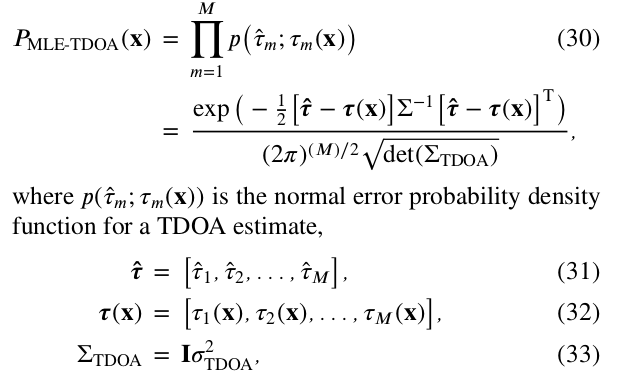

Where $M$ is the number of all possible mic combinations

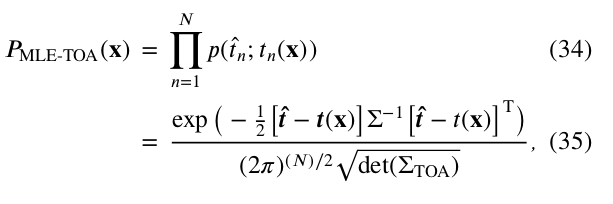

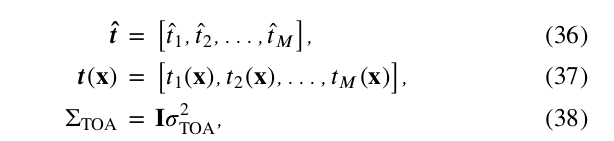

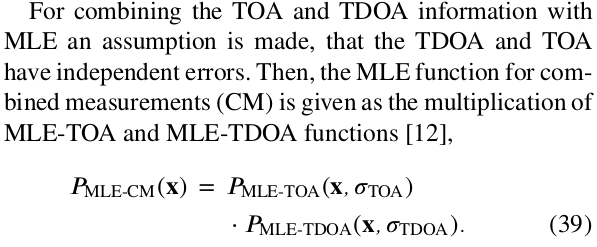

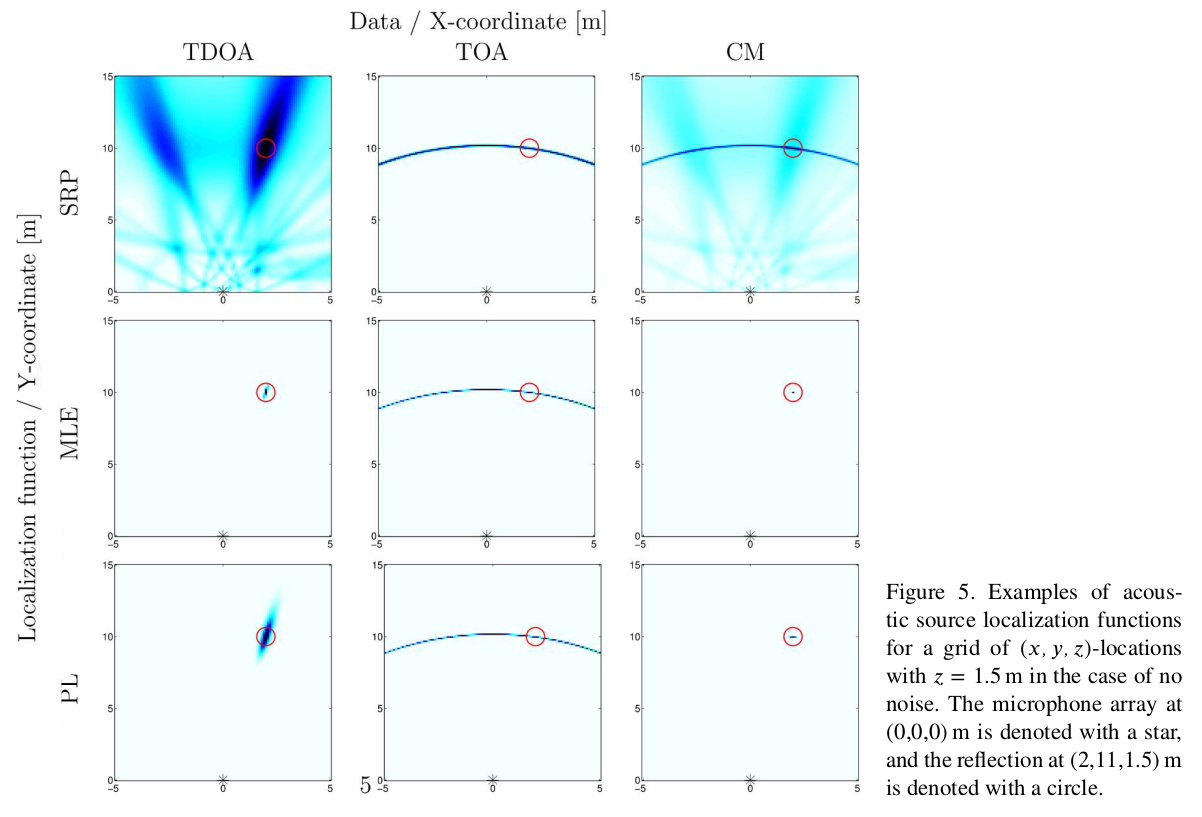

Emil's notes: This case is trivial and not interesting but it presents the "problem"
1. There's only one reflector
2. There's no noise. 
3. Examining the TDOA the peak is unrealistic. It's only possible if there's substantial $\phi_2$ or no noise at all. From my experience when the distance is 2x the aperture $\phi_2$ drops like crazy 

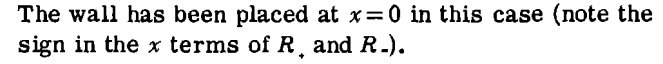

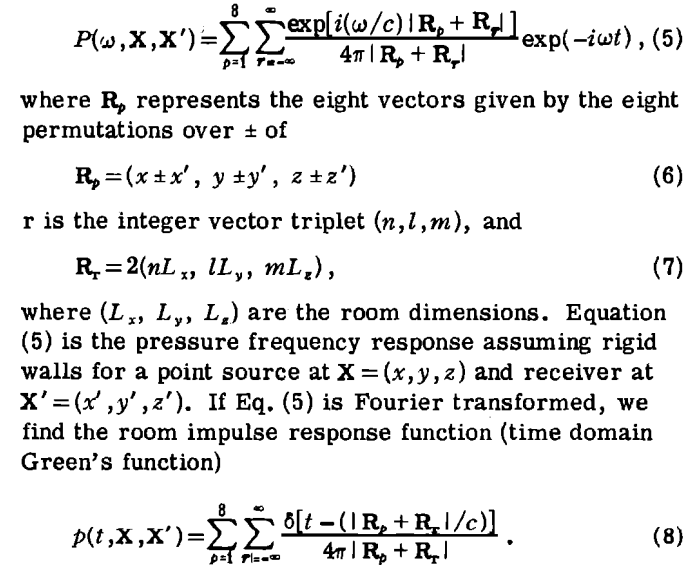

Emil's note: This assumes that the walls meet at (0,0,0)

In [46]:
def triplet_combinations(base_vec):
    vec = np.stack(np.meshgrid(base_vec,base_vec,base_vec))
    vec = np.stack(np.meshgrid(base_vec,base_vec,base_vec))
    return vec.reshape(3,len(base_vec)**3).T

def get_tau_set(src,tar,reflection_orders,rm_dims):
    tau_test = []
    for sgn_line in triplet_combinations([-1,1]):
        rp = src + sgn_line*tar
        for nlm in triplet_combinations(reflection_orders):
            rr = 2*nlm*rm_dims
            t = np.linalg.norm(rp+rr)/343
            tau_test.append(t)
    tau_test = np.array(tau_test)
    return tau_test

# tau_test    =  get_tau_set(pos_src,pos_rcv[0],
#                            np.arange(-2,3),room_sz)

tau0_cutoff =  df[(df.rcv==0) & (df.src ==0)].TAU.iloc[0]\
    [df[(df.rcv==0) & (df.src ==0)].TAU.iloc[0] < te_mix]

tau1_cutoff =  df[(df.rcv == 1) & (df.src == 0)].TAU.iloc[0]\
    [df[(df.rcv == 1) & (df.src ==0)].TAU.iloc[0] < te_mix]

# tau1_cutoff =  1000*Taus[0,1][(1000*Taus[0,1]/fs < 20)]/fs
# print(tau0_cutoff)

In [47]:
def cost_func(idx,s_pos):
    t_pos0 = s_pos + pos_rcv[0] - pos_src
    t_pos1 = s_pos + pos_rcv[1] - pos_src

    tau_test0 = get_tau_set(s_pos,t_pos0,np.arange(-2,3),room_sz)
    tau_test1 = get_tau_set(s_pos,t_pos1,np.arange(-2,3),room_sz)
    
    tau_test0 = tau_test0[1000*tau_test0<te_mix]*1000
    tau_test1 = tau_test1[1000*tau_test1<te_mix]*1000    
    
    tau_stack0 = np.stack(np.meshgrid(tau0_cutoff,tau_test0))
    tau_stack1 = np.stack(np.meshgrid(tau1_cutoff,tau_test1))
    
    ## L1 criteria
    cost0 = np.abs(np.diff(tau_stack0,axis=0)).squeeze()
    cost1 = np.abs(np.diff(tau_stack1,axis=0)).squeeze()
    
    ## Linear assignment solution
    row_ind0, col_ind0 = linear_sum_assignment(cost0)
    row_ind1, col_ind1 = linear_sum_assignment(cost1)
    
    loss = cost0[row_ind0, col_ind0].sum() + cost1[row_ind1, col_ind1].sum()
    tau_range0[idx] = loss

    
# pool = Pool (processes=6)
# pool.map(func, xyz)
# pool.close()


In [48]:
te_mix = 10

In [51]:
## Optimal 2D positioning
x_range = np.arange(0,3,0.1)
y_range = np.arange(0,3,0.1)

xyz = np.stack(np.meshgrid(x_range,y_range,[1]))
xyz = xyz.reshape(3,-1).T

loss_func = np.zeros(len(xyz))

for idx, s_pos in enumerate(xyz):
    t_pos0 = s_pos + pos_rcv[0] - pos_src
    t_pos1 = s_pos + pos_rcv[1] - pos_src

    tau_test0 = get_tau_set(s_pos,t_pos0,np.arange(-2,3),room_sz)
    tau_test1 = get_tau_set(s_pos,t_pos1,np.arange(-2,3),room_sz)
    
    tau_test0 = 1000*tau_test0[1000*tau_test0<te_mix]
    tau_test1 = 1000*tau_test1[1000*tau_test1<te_mix]
        
    tau_stack0 = np.stack(np.meshgrid(tau0_cutoff,tau_test0))
    tau_stack1 = np.stack(np.meshgrid(tau1_cutoff,tau_test1))
    
    ## L1 criteria
    cost0 = np.abs(np.diff(tau_stack0,axis=0)).squeeze()
    cost1 = np.abs(np.diff(tau_stack1,axis=0)).squeeze()
    
    ## Linear assignment solution
    row_ind0, col_ind0 = linear_sum_assignment(cost0)
    row_ind1, col_ind1 = linear_sum_assignment(cost1)
    
    loss = cost0[row_ind0, col_ind0].sum() + cost1[row_ind1, col_ind1].sum()
    loss_func[idx] = loss


<IPython.core.display.Javascript object>


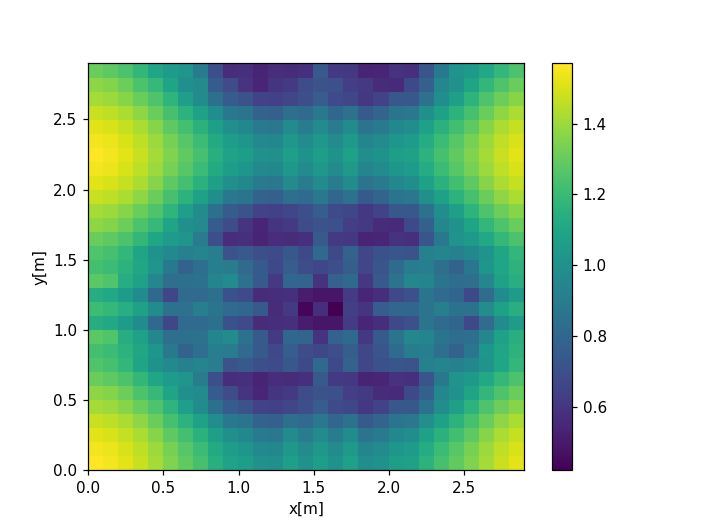

In [53]:
plt.figure()
plt.pcolormesh(x_range,y_range,np.log10(np.array(loss_func)).reshape(30,30))
plt.colorbar()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.show()

In [26]:
## Solve the problem with TAUs directly
## show 2d solution of reflector location
## Effect of noise on accuracy, white and diffused
## Histogram of reflections TDOAs
## TAU density v.s. time


### Summary
1. Room acoustics
    * Early and Late reflections
    * Diffused v.s. Specular
    * Frequency dependence
    * Noise sources
        - Diffused noise $\sin(d)/d$ 
        - White noise - microphone noise floor.
        - Don't know which dominates at 30kHz?
    * Microphone calibration. Phase detireoration
2. Sampling signal
    * Bandwidth
    * Analysis window
    * Energy decay threshold
    * Sampling with the carrier v.s. envelope
    * Optimal STFT window
    *
    
3. TDOA and TOA
    * $\phi_0$ , $\phi_1$, $\phi_2$
    * 
4. Room Localization
    * Radial and angular
    * Ambiguities and ghosts
        - Array ambiguities
        - Localization ghosts        
    * What happens if you only see the from coming peaks...?
